# 오토인코더 - 오래된 흑백 사진을 흐릿한 컬러 사진으로 복원하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/데이터/텐서플로우

/content/drive/MyDrive/데이터/텐서플로우


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## [1] 데이터셋의 이해

- 원본의 경우 800*600의 사람 이미지와 배경에 대한 흑백 이미지
- 작은 용량의 pfcn_small데이터 사용
- float64 타입의 1700개 train데이터와 300개의 test데이터로 구성.

## [2] 자료 로딩 및 검수

### 1-1. pfcn_small.npz 파일 읽기


In [ ]:
data=np.load('pfcn_small.npz')
print(list(data))
train_images = data['train_images']   # y값이 될 이미지
test_images = data['test_images']     # y값 이미지

['train_images', 'test_images', 'train_mattes', 'test_mattes']


In [ ]:
print('y train=>',np.shape(train_images)) # 사이즈가 높이 100, 너비 75이고 컬러인 이미지가 1700장 있음
print('y test=>',np.shape(test_images)) # 사이즈가 높이 100, 너비 75이고 컬러인 이미지가 300장 있음

y train=> (1700, 100, 75, 3)
y test=> (300, 100, 75, 3)


In [ ]:
# 스케일링이 된 자료인지 확인 => 0과 1사이의 값이 나오면 스케일링 된 것!

print('----------train data-----------')
print(train_images.min(), train_images.max())

print('----------test data-----------')
print(test_images.min(), test_images.max())

----------train data-----------
0.0 1.0
----------test data-----------
0.0 1.0


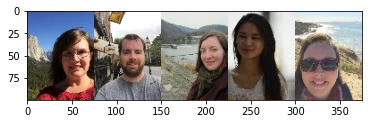

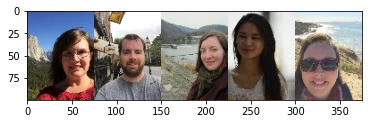

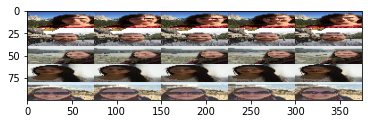

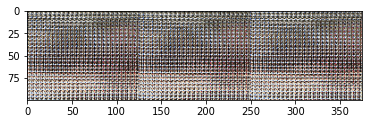

In [ ]:
plt.imshow(np.hstack(train_images[:5])) # np.hstack: 수평으로 이미지 나열
plt.show()
# 5개의 이미지를 하나의 이미지로 reshape하여 출력
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((100, -1, 3))) # shape변화: (5, 100, 75, 3) -> (100, 5, 75, 3) -> (100, 375, 3)
plt.show()
plt.imshow(train_images[:5].reshape((100, 375, 3)))
plt.show()
plt.imshow(train_images[:5].transpose((2,1,0,3)).reshape((100, -1, 3))) # shape변화: (5, 100, 75, 3) -> (75, 100, 5, 3) -> (100, 375, 3)
plt.show()

## [3] x데이터 제작 및 모델링

In [ ]:
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images]) # 높이가 100, 너비가 75인 흑백사진으로 바꿈.
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


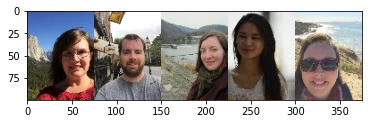

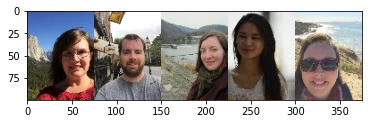

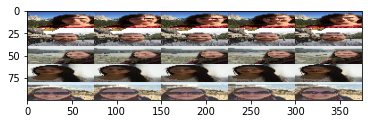

In [ ]:
# 작업- 아래의 출력물과 같이 train_gray_images도 위의 컬러 자료와 같이 출력 
plt.imshow(np.hstack(train_images[:5]))
plt.show()
# 5개의 이미지를 하나의 이미지로 reshape하여 출력
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((100, -1, 3)))
plt.show()
plt.imshow(train_images[:5].reshape((100, 375, 3)))
plt.show()

In [ ]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel): # Conv2D층 구성
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x) # 배치 정규화
    x = Activation("relu")(x) # relu 활성화함수 사용

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_color(): # U-net 모델링
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1) # MaxPool2D층: 해당 윈도우에서 가장 큰 값을 특징값으로 사용
    p1 = Dropout(0.1)(p1) # 드롭아웃: 학습이 진행되는 동안 신경망의 일부 유닛을 제외, 과대적합을 피하기 위해 사용

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9) # (100,75,3)
    model = Model(inputs, outputs)
    return model

In [ ]:
# 위자료와 param및 shape 갯수 맞는지 확인
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# 주석작성 텐서플로우의 optimizer 의 종류와 특성
# 1. 확률적 경사 하강법 (Stochastic Gradient Descent : SGD): 신경망 학습의 가장 기본적인 방식. 
#    오차역전파법을 이용하여, 갱신시킬 파라미터들의 현 기울기 값인 그래디언트를 구해내고, 그것에 일정한 학습률을 곱하고, 기존 파라미터에 적용시키는 방식으로 갱신시킵니다.
# 2. 모멘텀 (momentum): 모멘텀의 뜻은 운동량. 경사 위에서 아래로 흘러가는 학습을 일종의 물리적인 운동으로 보고 만들어진 옵티마이저
# 3. Nesterov Accelerated Gradient (NAG): Momentum 방식을 개선한 것입니다. 운동량에 따른 변동사항을 먼저 적용시키고, 이후에 그것에 대한 grad를 구하여 갱신을 시킨다는 개념
# 4. AdaGrad: 각 변수들에 대해 lr이 따로따로 적응하여 작용
# 5. RMSProp: AdaGrad를 개선한 방식으로, 학습률 소실 문제를 해결하기 위한 방안
# 6. AdaDelta: AdaGrad를 개선하기 위해 나온 방식, RMSProp을 기반으로 하며, 학습률 설정부분을 지우고, 이를 자동화한다는 것에 의의
# 7. Adam: 현재 가장 자주 사용되는 옵티마이저,  Adagrad와 momentum의 결합
# (참고) https://wiserloner.tistory.com/1032

model.compile(loss = "mse", optimizer="adam", metrics=["accuracy"])

In [ ]:
# 주석작성: verbose 옵션값의 차이
# 0 = silent
# 1 = progress bar
# 2 = one line per epoch

hist = model.fit(train_gray_images, train_images, validation_data=(test_gray_images, test_images), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 41s 144ms/step - loss: 0.0372 - accuracy: 0.6074 - val_loss: 0.0680 - val_accuracy: 0.6857
Epoch 2/50
54/54 [==============================] - 6s 116ms/step - loss: 0.0163 - accuracy: 0.6496 - val_loss: 0.0618 - val_accuracy: 0.6882
Epoch 3/50
54/54 [==============================] - 6s 116ms/step - loss: 0.0117 - accuracy: 0.6540 - val_loss: 0.0559 - val_accuracy: 0.6892
Epoch 4/50
54/54 [==============================] - 6s 118ms/step - loss: 0.0096 - accuracy: 0.6504 - val_loss: 0.0470 - val_accuracy: 0.6575
Epoch 5/50
54/54 [==============================] - 6s 116ms/step - loss: 0.0089 - accuracy: 0.6498 - val_loss: 0.0374 - val_accuracy: 0.4841
Epoch 6/50
54/54 [==============================] - 6s 117ms/step - loss: 0.0083 - accuracy: 0.6435 - val_loss: 0.0330 - val_accuracy: 0.6480
Epoch 7/50
54/54 [==============================] - 6s 116ms/step - loss: 0.0079 - accuracy: 0.6461 - val_loss: 0.0254 - val_accuracy: 0.6614
Epoch

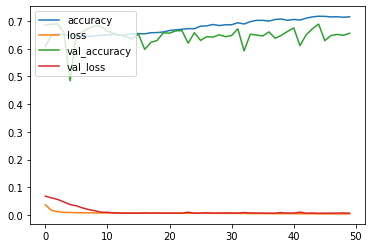

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
res = model.predict(test_gray_images[1:2]) # test_gray_images의 두번째 이미지를 사용하여 예측
print(test_gray_images[1:2].shape) # test_gray_images의 shape
print(res.shape) # 예측한 결과의 shape, 컬러로 출력됨.

(1, 100, 75, 1)
(1, 100, 75, 3)


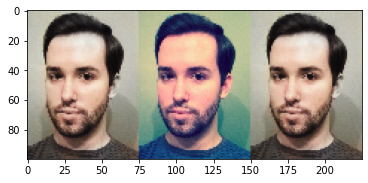

In [ ]:
# res[0]: 앞에서 예측한 결과, test_images[1]: pfcn의 두번째 이미지, model.predict(test_gray_images[1:2])[0]: res[0]과 동일하다.
# np.concatenate를 사용하여 가로로 연결하여 출력하였다.
plt.imshow(np.concatenate([res[0], test_images[1], model.predict(test_gray_images[1:2])[0]], axis=1))
plt.show()

In [ ]:
test_gray_images[1].shape

(100, 75, 1)

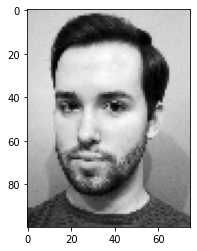

In [ ]:
plt.imshow(test_gray_images[1][...,0], cmap="gray") # test_gray_images의 두 번째 그림의 가장 마지막 축에서 첫 번째 인자를 가져옴. (100, 75, 1) -> (100, 75)
plt.show()

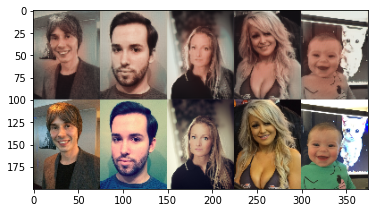

In [ ]:
# 결과 확인
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))
plt.shoW()

## [4] lab 칼라 모델링
- Lab Color
    - 컬러 공간에서 특정 거리를 둔 컬러가 인간의 지각으로 같은 거리로 인지되는 것을 목표로 한 색상모드이다.
    - 디스플레이나 프린터에 따라서 색상이 달라지지 않는 독립적인 성격을 갖기 위해서 국제조명위원회(CIE)에서 인간의 지각에 대한 연구를 통해 정의된 방식이다.
    - Lab 색상은 RGB나 CMYK 색상이 표현할 수 있는 모든 범위를 포함하여 더 정밀하게 표현된다.
    - Lab 색상의 범위는 디스플레이나 프린터는 물론 인간의 지각 범위보다 크기 때문에 인간이 지각할 수 없는 컬러도 포함한다.
    - L: 반사율(밝기), 0: 검정, 1: 하양
    - a: 빨강-초록, -a: 초록 방향, +a: 빨강 방향
    - b: 노랑-파랑, -b: 파랑 방향, +b: 노랑 방향
    - Lab 색상은 RGB색상의 이미지를 CMYK 색상으로 전환하기 전 중간단계로 활용하면 좋다.
    - [참고](https://mamasajang.tistory.com/entry/%EC%83%89%EC%83%81%EB%AA%A8%EB%93%9C-RGB-CMYK-Grayscale-Lab)

In [ ]:
train_lab_images = np.array([color.rgb2lab(img) for img in train_images]) # rgb컬러를 lab컬러로 변경
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [ ]:
print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max()) # train_lab_images의 밝기 값의 최솟값, 최댓값
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max()) # train_lab_images의 빨강-초록 값의 최솟값, 최댓값
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max()) # train_lab_images의 노랑-파랑 값의 최솟값, 최댓값

0.0 100.0
-78.53736435567544 86.20773183914271
-91.97308466277427 93.80664030542576


In [ ]:
a = train_lab_images + [0, 128, 128] # 빨강-초록값에 +128, 노랑-파랑 값에 +128을 한다.
print(a[...,0].min(), a[...,0].max()) # train_lab_images의 밝기 값의 최솟값, 최댓값
print(a[...,1].min(), a[...,1].max()) # train_lab_images의 빨강-초록 값의 최솟값, 최댓값
print(a[...,2].min(), a[...,2].max()) # train_lab_images의 노랑-파랑 값의 최솟값, 최댓값

b = a / [100., 255., 255.] # 스케일링
print(b[...,0].min(), b[...,0].max()) # 스케일링한 train_lab_images의 밝기 값의 최솟값, 최댓값
print(b[...,1].min(), b[...,1].max()) # 스케일링한 train_lab_images의 빨강-초록 값의 최솟값, 최댓값
print(b[...,2].min(), b[...,2].max()) # 스케일링한 train_lab_images의 노랑-파랑 값의 최솟값, 최댓값



0.0 100.0
49.462635644324564 214.2077318391427
36.02691533722573 221.80664030542576
0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


In [ ]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

In [ ]:
print(train_lab_images[...,0].min(), train_lab_images[...,0].max())
print(train_lab_images[...,1].min(), train_lab_images[...,1].max())
print(train_lab_images[...,2].min(), train_lab_images[...,2].max())


0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


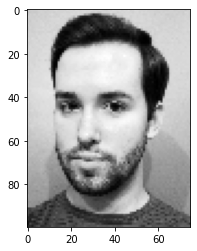

In [ ]:
plt.imshow(test_lab_images[1][...,0], cmap="gray")
plt.show()     
# 스케일링한 train data의 두번째 사진에서 밝기 값만으로 이미지 출력

-  lab 칼라 첫번째 채널로 나머지 2채널을 예측하는 모델

In [ ]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [ ]:
model2 = unet_lab()
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 100, 75, 16)  160         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 100, 75, 16)  64          conv2d_187[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 100, 75, 16)  0           batch_normalization_182[0][0]    
____________________________________________________________________________________________

In [ ]:
model2.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

In [ ]:
hist = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:], validation_data=(test_lab_images[...,0:1], test_lab_images[...,1:]), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 57ms/step - loss: 0.0898 - accuracy: 0.5519 - val_loss: 0.1665 - val_accuracy: 0.4765
Epoch 2/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0358 - accuracy: 0.5887 - val_loss: 0.0403 - val_accuracy: 0.5922
Epoch 3/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0343 - accuracy: 0.5997 - val_loss: 0.0749 - val_accuracy: 0.5536
Epoch 4/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0340 - accuracy: 0.5921 - val_loss: 0.0565 - val_accuracy: 0.5837
Epoch 5/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0336 - accuracy: 0.6058 - val_loss: 0.0520 - val_accuracy: 0.5705
Epoch 6/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0341 - accuracy: 0.6098 - val_loss: 0.0438 - val_accuracy: 0.5907
Epoch 7/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0330 - accuracy: 0.6115 - val_loss: 0.0359 - val_accuracy: 0.5992
Epoch 8/50
54

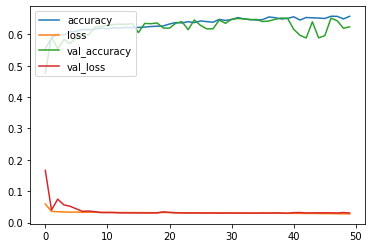

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
res = model2.predict(test_lab_images[1:2][...,0:1])

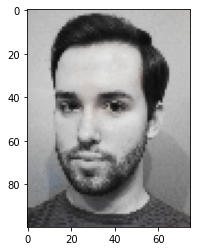

In [ ]:
def l2rgb(l):
    pred_ab = model2.predict(np.expand_dims(l, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = l.reshape((100,75))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


plt.imshow(  l2rgb(test_lab_images[1][...,0]) )

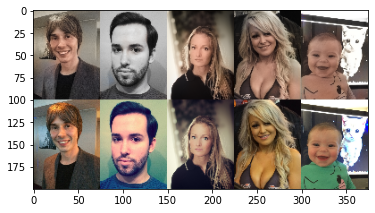

In [ ]:
five = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))

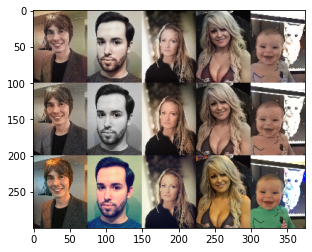

In [ ]:
five1 = model.predict(test_gray_images[:5])
five2 = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five1, five2, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((300, -1,3)))

In [ ]:
loss, acc = new_model.evaluate(test_lab_images[...,0], test_lab_images[...,1:], verbose=1)
print(loss, acc)

10/10 [==============================] - 1s 19ms/step - loss: 0.0306 - accuracy: 0.6238
0.030649233609437943 0.6237773299217224
